In [1]:
#import packages
import tensorflow as tf
from tensorflow.keras import Sequential, layers, Model, Input, optimizers, losses
import numpy as np
from matplotlib import pyplot as plt
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm
import time

plt.style.use("seaborn")

In [2]:
# get word embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-08-21 16:22:39--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-08-21 16:22:39--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-08-21 16:22:40--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [3]:
# fetch dataset
 
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
 
api_token = {"username":"badasstechie","key":"17559c6155570222ecdcb9ecea36c1cb"}
 
import json
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
 
!chmod 600 ~/.kaggle/kaggle.json
 
!kaggle --version
!kaggle datasets download arashnic/7-nlp-tasks-with-tweets

!unzip -q 7-nlp-tasks-with-tweets.zip

Kaggle API 1.5.4
 62% 5.00M/8.01M [00:00<00:00, 24.6MB/s]
100% 8.01M/8.01M [00:00<00:00, 31.6MB/s]


In [4]:
# constants

EMBEDDING_DIM = 300
MAPPINGS = [line.split()[1] for line in open('/content/datasets/emotion/mapping.txt').readlines() if line != '']
OUTPUT_DIM = len(MAPPINGS)

In [5]:
# prepare dictionary

WORD_TO_INDEX = {}
EMBEDDING_MATRIX = [np.zeros(300)] #word at index 0 is the <UNKNOWN> token and has embeddings of zero

def prepare_embeddings(filepath):
    global EMBEDDING_MATRIX
    with open(filepath) as f:
        for ix, line in enumerate(f):
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            WORD_TO_INDEX[word] = ix+1  #we start at 1 because 0 is reserved for the <UNKNOWN> token
            EMBEDDING_MATRIX += [coefs]
    EMBEDDING_MATRIX = np.vstack(EMBEDDING_MATRIX).astype(np.float32)

prepare_embeddings('/content/glove.6B.300d.txt')

In [6]:
# tokenize and vectorize dataset

tokenizer = RegexpTokenizer(r'\w+')
TRAIN_X = [[WORD_TO_INDEX.get(word.lower(), 0) for word in tokenizer.tokenize(line)] for line in open('/content/datasets/emotion/train_text.txt').readlines() if line != '']  # tokenize then represent each word with its index in embedding matrix
max_seq_length = max([len(seq) for seq in TRAIN_X])
TRAIN_X = [seq + ([0] * (max_seq_length - len(seq))) for seq in TRAIN_X]  #pad zeros (<UNKNOWN> token) at end
TRAIN_X = np.array(TRAIN_X, dtype=np.int32)

TRAIN_Y = [int(line) for line in open('/content/datasets/emotion/train_labels.txt').readlines() if line != '']
for i in range(len(TRAIN_Y)):
    arr = np.zeros((OUTPUT_DIM))
    arr[TRAIN_Y[i]] = 1
    TRAIN_Y[i] = arr
TRAIN_Y = np.array(TRAIN_Y, dtype=np.float32)


TEST_X = [[WORD_TO_INDEX.get(word.lower(), 0) for word in tokenizer.tokenize(line)] for line in open('/content/datasets/emotion/test_text.txt').readlines() if line != '']
max_seq_length = max([len(seq) for seq in TEST_X])
TEST_X = [seq + ([0] * (max_seq_length - len(seq))) for seq in TEST_X]  #pad zeros (<UNKNOWN> token) at end
TEST_X = np.array(TEST_X, dtype=np.int32)

TEST_Y = [int(line) for line in open('/content/datasets/emotion/test_labels.txt').readlines() if line != '']
for i in range(len(TEST_Y)):
    arr = np.zeros((OUTPUT_DIM))
    arr[TEST_Y[i]] = 1
    TEST_Y[i] = arr
TEST_Y = np.array(TEST_Y, dtype=np.float32)


VALID_X = [[WORD_TO_INDEX.get(word.lower(), 0) for word in tokenizer.tokenize(line)] for line in open('/content/datasets/emotion/val_text.txt').readlines() if line != '']
max_seq_length = max([len(seq) for seq in VALID_X])
VALID_X = [seq + ([0] * (max_seq_length - len(seq))) for seq in VALID_X]  #pad zeros (<UNKNOWN> token) at end
VALID_X = np.array(VALID_X, dtype=np.int32)

VALID_Y = [int(line) for line in open('/content/datasets/emotion/val_labels.txt').readlines() if line != '']
for i in range(len(VALID_Y)):
    arr = np.zeros((OUTPUT_DIM))
    arr[VALID_Y[i]] = 1
    VALID_Y[i] = arr
VALID_Y = np.array(VALID_Y, dtype=np.float32)
    

In [18]:
# helper functions

#displays time as h:mm:ss
def format_time(seconds):
    return "{}:{:0>2}:{:0>2}".format(int(seconds//3600), int((seconds//60)%60), int(seconds%60))

#loads a batch from the dataset into memory
def get_batch(batch_size, set='train'):
    if set == 'train':
        indices = np.random.randint(len(TRAIN_X), size=batch_size)
        return TRAIN_X[indices], TRAIN_Y[indices]
    elif set == 'test':
        indices = np.random.randint(len(TEST_X), size=batch_size)
        return TEST_X[indices], TEST_Y[indices]
    elif set == 'valid':
        lines = np.array([line for line in open('/content/datasets/emotion/val_text.txt').readlines() if line != ''])
        indices = np.random.randint(len(VALID_X), size=batch_size)
        return VALID_X[indices], VALID_Y[indices], lines[indices]

In [12]:
def build_model(rnn_units=1024):
    return Sequential([
        layers.Embedding(input_dim=EMBEDDING_MATRIX.shape[0], output_dim=EMBEDDING_DIM, weights=[EMBEDDING_MATRIX], trainable=False),
        layers.LSTM(input_dim=EMBEDDING_DIM, units=rnn_units, return_sequences=True),
        layers.Dropout(0.5),
        layers.LSTM(units=rnn_units, return_sequences=False),
        layers.Dropout(0.5),
        layers.Dense(OUTPUT_DIM, activation='softmax')
    ])

In [16]:
@tf.function
def train_step(model, optimizer, x, y):
    with tf.GradientTape() as tape:
        y_hat = model(x)
        loss = losses.categorical_crossentropy(y, y_hat)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

def train(model, batch_size=32, lr=0.001, iterations=50000):
    print("Training...")
    opt=optimizers.Adam(learning_rate=lr)
    loss_history = []
    prev_time = time.time()
    time_elapsed = 0
    for iteration in tqdm(range(iterations)):
        #grab a batch and propagate it through the network
        x_batch, y_batch = get_batch(batch_size)
        loss = train_step(model, opt, x_batch, y_batch)

        #update the loss history
        loss_history.append(loss.numpy().mean())

        #save weights after every 100 iterations
        if iteration % 1000 == 0:
            Sequential(model.layers[1:]).save_weights("rnn.h5") # skip embedding layer (1st layer)

        time_elapsed += time.time() - prev_time
        prev_time = time.time()
        #print("iteration {} of {}. Loss: {}. Time elapsed: {} seconds.".format(iteration+1, iterations, loss.numpy().mean(), time_elapsed))

    # Save the trained model and the weights
    Sequential(model.layers[1:]).save_weights("rnn.h5") # skip embedding layer (1st layer)

    #plot a graph that will show how our loss varied with time
    plt.plot(loss_history)
    plt.title("Training progress")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.show()


In [13]:
model = build_model()
model.summary()
train(model)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         120000300 
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 1024)        5427200   
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 1024)        0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1024)              8392704   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 4100      
Total params: 133,824,304
Trainable params: 13,824,004
Non-trainable params: 120,000,300
_______________________________

Training...


100%|██████████| 10000/10000 [16:04<00:00, 10.37it/s]


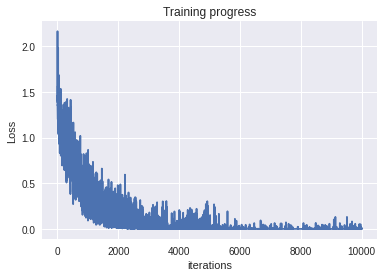

In [36]:
# inference

seqs, labels, lines =  get_batch(50, 'valid')
logits = model(seqs)
for line, label, logit in zip(lines, labels, logits):
    print(f"Input: {line}Actual: {MAPPINGS[np.argmax(label)]}\nPredicted:{MAPPINGS[np.argmax(logit)]}\n")

Input: Sarah is a complete lunatic. How Chad is still giving her his time is beyond me. #cbb #mad #crazy 
Actual: anger
Predicted:anger

Input: #depressed Today was bitter sweet watching all the kids go back to school made me really miss my babies. I'm so broke #backtoschool2017 
Actual: sadness
Predicted:sadness

Input: today i feel like an exposed wire dangerously close to another exposed wire and any provocation will fry me 
Actual: anger
Predicted:anger

Input: Counting on you, Queensland. #StateOfOrigin #Broncos #maroons #blues #NSWBlues #qld 
Actual: joy
Predicted:sadness

Input: The next time I go to Lagos I will gate crash somebody's owambe dressed in lace and gele to eat amala and shake my waist😑 
Actual: joy
Predicted:sadness

Input: @user @user what the phd!  eesav gattiga 😆 
Actual: joy
Predicted:joy

Input: @user Very sad and upset and idk :/ 
Actual: sadness
Predicted:sadness

Input: @user thanks Hollywood, (Depp). all these climate change fanatics using private jets and 